## Test best-of-call

What we want to do is to compute

$$ payoff = \max(x_1-k_1, x_2-k_2, 0)$$

In [48]:
import numpy as np
from qiskit_finance.circuit.library import LogNormalDistribution
# number of qubits per dimension to represent the uncertainty
num_uncertainty_qubits = 3

# parameters for considered random distribution
S = 2.0  # initial spot price
vol = 0.4  # volatility of 40%
r = 0.04  # annual interest rate of 4%
T = 40 / 365  # 40 days to maturity

# resulting parameters for log-normal distribution
mu = (r - 0.5 * vol**2) * T + np.log(S)
sigma = vol * np.sqrt(T)
mean = np.exp(mu + sigma**2 / 2)
variance = (np.exp(sigma**2) - 1) * np.exp(2 * mu + sigma**2)
stddev = np.sqrt(variance)

# lowest and highest value considered for the spot price; in between, an equidistant discretization is considered.
low = np.maximum(0, mean - 3 * stddev)
high = mean + 3 * stddev

# map to higher dimensional distribution
# for simplicity assuming dimensions are independent and identically distributed)
dimension = 2
num_qubits = [num_uncertainty_qubits] * dimension
low = low * np.ones(dimension)
high = high * np.ones(dimension)
mu = mu * np.ones(dimension)
cov = sigma**2 * np.eye(dimension) # covariance matrix

# construct circuit
u = LogNormalDistribution(num_qubits=num_qubits, mu=mu, sigma=cov, bounds=list(zip(low, high)))
print(u)

     ┌───────┐
q_0: ┤0      ├
     │       │
q_1: ┤1      ├
     │       │
q_2: ┤2      ├
     │  P(X) │
q_3: ┤3      ├
     │       │
q_4: ┤4      ├
     │       │
q_5: ┤5      ├
     └───────┘


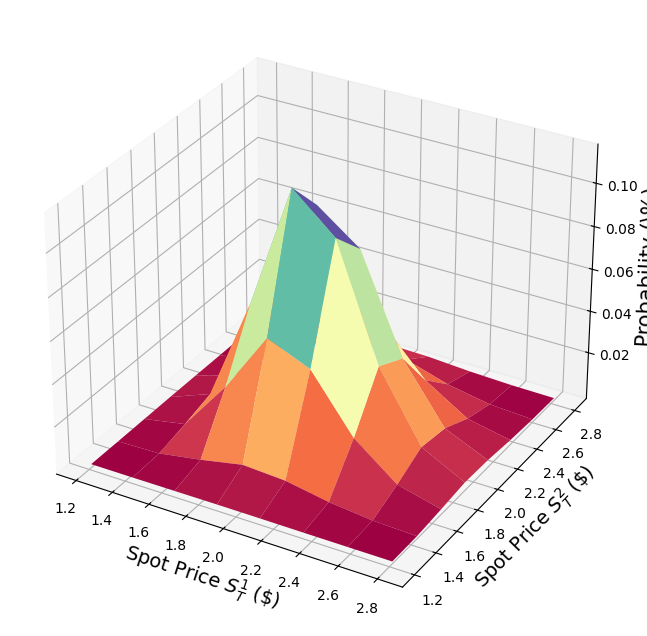

In [49]:
from scipy.interpolate import griddata
import matplotlib.pyplot as plt

# plot PDF of uncertainty model
x = [v[0] for v in u.values]
y = [v[1] for v in u.values]
z = u.probabilities
# z = map(float, z)
# z = list(map(float, z))
resolution = np.array([2**n for n in num_qubits]) * 1j
grid_x, grid_y = np.mgrid[min(x) : max(x) : resolution[0], min(y) : max(y) : resolution[1]]
grid_z = griddata((x, y), z, (grid_x, grid_y))
plt.figure(figsize=(10, 8))
ax = plt.axes(projection="3d")
ax.plot_surface(grid_x, grid_y, grid_z, cmap=plt.cm.Spectral)
ax.set_xlabel("Spot Price $S_T^1$ (\$)", size=14)
ax.set_ylabel("Spot Price $S_T^2$ (\$)", size=14)
ax.set_zlabel("Probability (\%)", size=15)
plt.show()


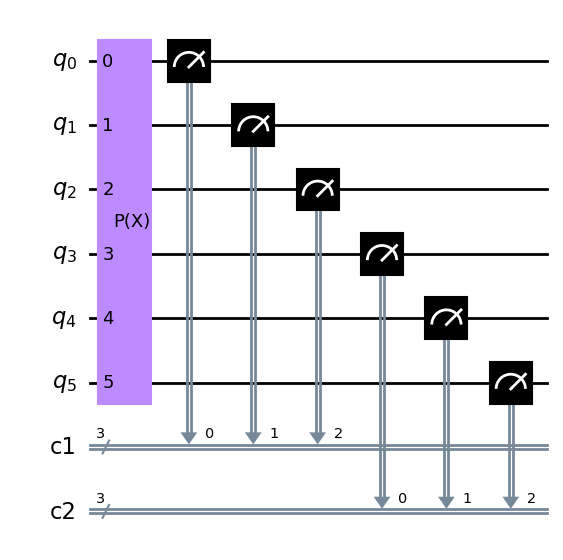

In [50]:
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister

q_reg = QuantumRegister(u.num_qubits, name='q')
first_num_register = ClassicalRegister(num_uncertainty_qubits, name='c1')
second_num_register = ClassicalRegister(num_uncertainty_qubits, name='c2')


test_circuit = QuantumCircuit(q_reg, first_num_register, second_num_register)
test_circuit.append(u, test_circuit.qubits)
test_circuit.measure(test_circuit.qubits[:num_uncertainty_qubits], first_num_register)
test_circuit.measure(test_circuit.qubits[num_uncertainty_qubits:], second_num_register)
test_circuit.draw(output='mpl')

{'001 010': 2, '111 110': 1, '101 111': 2, '111 100': 3, '110 101': 4, '100 110': 8, '110 001': 2, '011 001': 4, '100 001': 4, '001 011': 7, '011 111': 5, '010 111': 1, '001 101': 5, '100 111': 5, '010 010': 35, '001 100': 7, '010 100': 47, '011 010': 56, '110 010': 7, '001 110': 2, '010 011': 56, '011 101': 35, '011 110': 16, '100 010': 56, '111 011': 4, '100 101': 39, '110 100': 11, '101 110': 5, '101 010': 30, '101 001': 5, '101 100': 37, '010 001': 5, '101 011': 36, '111 010': 5, '010 110': 5, '100 011': 95, '011 100': 86, '001 111': 1, '110 110': 6, '100 100': 85, '101 101': 24, '011 011': 126, '110 011': 11, '000 101': 1, '010 101': 13}


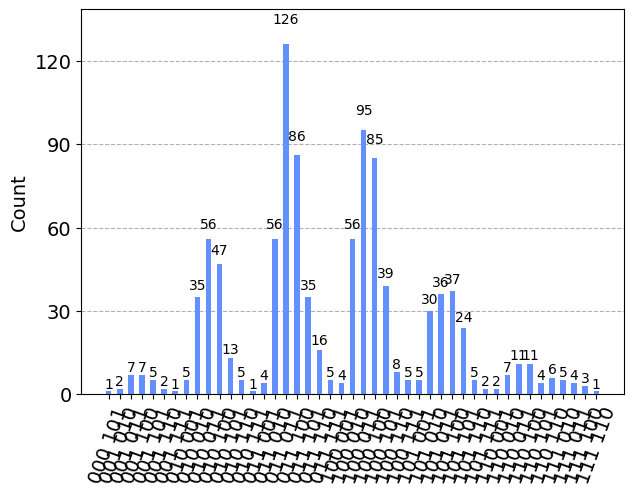

In [51]:
from qiskit import execute, Aer

job = execute(test_circuit, Aer.get_backend('aer_simulator'), shots=1000)
results = job.result()
counts = results.get_counts()
print(counts)
# print(counts)
from qiskit.visualization import plot_histogram
plot_histogram(counts)

## strike 1

In [52]:
from qiskit.circuit.library import LinearAmplitudeFunction
# set the strike price (should be within the low and the high value of the uncertainty)
strike_price_1 = 1.9

# set the approximation scaling for the payoff function
c_approx = 0.1

low = np.maximum(0, mean - 3 * stddev)
high = mean + 3 * stddev

# setup piecewise linear objective fcuntion
breakpoints = [low, strike_price_1] 
# low is the lower bound, strike price is where our payoff function starts to increase
slopes = [0, 1]
# can be float or list of floats.
# for list of floats, the floats are the slopes of the individual linear functions

offsets = [0, 0]
# the offsets of each linear function
f_min = 0
# minimum y value
f_max = high - strike_price_1
# maximum y value

call_objective_1 = LinearAmplitudeFunction(
    num_uncertainty_qubits,
    slopes,
    offsets,
    domain=(low, high),
    image=(f_min, f_max),
    breakpoints=breakpoints,
    rescaling_factor=c_approx,
)

print(call_objective_1)


        ┌────┐
q378_0: ┤0   ├
        │    │
q378_1: ┤1   ├
        │    │
q378_2: ┤2   ├
        │    │
  q379: ┤3 F ├
        │    │
 a50_0: ┤4   ├
        │    │
 a50_1: ┤5   ├
        │    │
 a50_2: ┤6   ├
        └────┘


## Strike 2

In [64]:
from qiskit.circuit.library import LinearAmplitudeFunction
# set the strike price (should be within the low and the high value of the uncertainty)
strike_price_2 = 1.7

# set the approximation scaling for the payoff function
c_approx = 0.1

low = np.maximum(0, mean - 3 * stddev)
high = mean + 3 * stddev

# setup piecewise linear objective fcuntion
breakpoints = [low, strike_price_2] 
# low is the lower bound, strike price is where our payoff function starts to increase
slopes = [0, 1]
# can be float or list of floats.
# for list of floats, the floats are the slopes of the individual linear functions

offsets = [0, 0]
# the offsets of each linear function
f_min = 0
# minimum y value
f_max = high - strike_price_2
# maximum y value

call_objective_2 = LinearAmplitudeFunction(
    num_uncertainty_qubits,
    slopes,
    offsets,
    domain=(low, high),
    image=(f_min, f_max),
    breakpoints=breakpoints,
    rescaling_factor=c_approx,
)

print(call_objective_2)

        ┌────┐
q856_0: ┤0   ├
        │    │
q856_1: ┤1   ├
        │    │
q856_2: ┤2   ├
        │    │
  q857: ┤3 F ├
        │    │
a220_0: ┤4   ├
        │    │
a220_1: ┤5   ├
        │    │
a220_2: ┤6   ├
        └────┘


## Exact payoff

In [65]:
probabilities = u.probabilities
values = u.values

expected_payoff = 0
for i in range(len(values)):
    expected_payoff += probabilities[i] * max(0, values[i][0] - strike_price_1, values[i][1] - strike_price_2)

print(f"Expected payoff: {expected_payoff:.4f}")

Expected payoff: 0.3781


# Build circuits

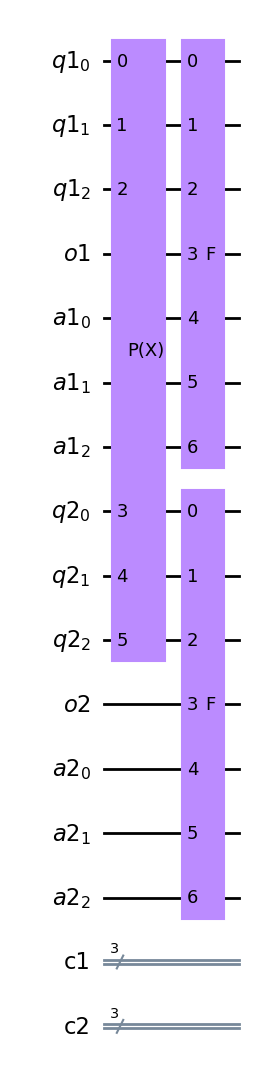

In [66]:
from qiskit import QuantumRegister, AncillaRegister, QuantumCircuit

first_num_register = QuantumRegister(num_uncertainty_qubits, name='q1')
second_num_register = QuantumRegister(num_uncertainty_qubits, name='q2')

first_classical_register = ClassicalRegister(num_uncertainty_qubits, name='c1')
second_classical_register = ClassicalRegister(num_uncertainty_qubits, name='c2')

first_ancilla_register = AncillaRegister(num_uncertainty_qubits, name='a1')
second_ancilla_register = AncillaRegister(num_uncertainty_qubits, name='a2')

first_objective_register = QuantumRegister(1, name='o1')
second_objective_register = QuantumRegister(1, name='o2')

test_circuit = QuantumCircuit(first_num_register, first_objective_register, first_ancilla_register, second_num_register, second_objective_register, second_ancilla_register, first_classical_register, second_classical_register)

test_circuit.append(u, first_num_register[:] + second_num_register[:])
test_circuit.append(call_objective_1, first_num_register[:] + first_objective_register[:] + first_ancilla_register[:])
test_circuit.append(call_objective_2, second_num_register[:] + second_objective_register[:] + second_ancilla_register[:])


test_circuit.draw(output='mpl')


## Full test Circuit

In [67]:
from qiskit import QuantumCircuit, QuantumRegister, AncillaRegister, ClassicalRegister
from package.helper import Subtractor
from package.qArithmetic import QComp

def loadNumber(circ: QuantumCircuit, register: QuantumRegister, number: int):
    number_in_binary = '0'*(register.size - len(bin(number)[2:])) + bin(number)[2:]
    for i in range(len(number_in_binary)):
        if number_in_binary[::-1][i] == '1':
            circ.x(register[i])
            
def map_strike_price(strike_price, high, low, num_uncertainty_qubits):
    return int((strike_price - low) / (high - low) * (2**num_uncertainty_qubits-1))



first_number_register = QuantumRegister(num_uncertainty_qubits, name='q1')
first_ancilla_register = QuantumRegister(num_uncertainty_qubits+1, name='a1')


second_number_register = QuantumRegister(num_uncertainty_qubits, name='q2')
second_ancilla_register = QuantumRegister(num_uncertainty_qubits+1, name='a2')

carry_register = QuantumRegister(1, name='carry')
compare_ancilla_register = QuantumRegister(3, name='comp')
objective_register = QuantumRegister(1, name='o')
objective_ancilla_register = QuantumRegister(num_uncertainty_qubits, name='oa')

test_circuit = QuantumCircuit(first_number_register, first_ancilla_register, second_number_register, second_ancilla_register, objective_register, carry_register, compare_ancilla_register, objective_ancilla_register)
subtractor = Subtractor(num_uncertainty_qubits).circuit
controlled_first_objective = call_objective_1.to_gate().control(1)
controlled_second_objective = call_objective_2.to_gate().control(1)


test_circuit.append(u, first_number_register[:] + second_number_register[:])

loadNumber(test_circuit, first_ancilla_register, map_strike_price(strike_price_1, high, low, num_uncertainty_qubits))
loadNumber(test_circuit, second_ancilla_register, map_strike_price(strike_price_2, high, low, num_uncertainty_qubits))

test_circuit.append(subtractor, first_number_register[:] + first_ancilla_register[:])
test_circuit.append(subtractor, second_number_register[:] + second_ancilla_register[:])

test_circuit.x(first_ancilla_register[-1])
test_circuit.x(second_ancilla_register[-1])



comparator = QComp(num_uncertainty_qubits+1, num_uncertainty_qubits+1)

test_circuit.append(comparator, first_ancilla_register[:] + second_ancilla_register[:] + carry_register[:] + compare_ancilla_register[:])

test_circuit.append(controlled_first_objective, [compare_ancilla_register[0]] + first_number_register[:] + objective_register[:] + objective_ancilla_register[:])
test_circuit.append(controlled_second_objective, [compare_ancilla_register[1]] + second_number_register[:] + objective_register[:] + objective_ancilla_register[:])
test_circuit.append(controlled_first_objective, [compare_ancilla_register[2]] + first_number_register[:] + objective_register[:] + objective_ancilla_register[:])

test_circuit.draw()


┌───────┐     ┌─────────────┐                ┌────┐      ┌────┐
  q1_0: ┤0      ├─────┤0            ├────────────────┤0   ├──────┤0   ├
        │       │     │             │                │    │      │    │
  q1_1: ┤1      ├─────┤1            ├────────────────┤1   ├──────┤1   ├
        │       │     │             │                │    │      │    │
  q1_2: ┤2      ├─────┤2            ├────────────────┤2   ├──────┤2   ├
        │       │┌───┐│             │     ┌─────────┐│    │      │    │
  a1_0: ┤       ├┤ X ├┤3 subtractor ├─────┤0        ├┤    ├──────┤    ├
        │       │├───┤│             │     │         ││    │      │    │
  a1_1: ┤       ├┤ X ├┤4            ├─────┤1        ├┤    ├──────┤    ├
        │  P(X) │└───┘│             │     │         ││    │      │    │
  a1_2: ┤       ├─────┤5            ├─────┤2        ├┤    ├──────┤    ├
        │       │     │             │┌───┐│         ││    │      │    │
  a1_3: ┤       ├─────┤6            ├┤ X ├┤3        ├┤    ├──────┤    ├
        │       │     ├─────────────┤└───┘│         ││    │┌────┐│    │
  q2_0: ┤3      ├─────┤0            ├─────┤         ├┤    ├┤0   ├┤    ├
        │       │     │             │     │         ││    ││    ││    │
  q2_1: ┤4      ├─────┤1            ├─────┤         ├┤    ├┤1   ├┤    ├
        │       │     │             │     │         ││    ││    ││    │
  q2_2: ┤5      ├─────┤2            ├─────┤         ├┤    ├┤2   ├┤    ├
        └───────┘     │             │     │         ││    ││    ││    │
  a2_0: ──────────────┤3 subtractor ├─────┤4        ├┤    ├┤    ├┤    ├
                 ┌───┐│             │     │   QComp ││  F ││    ││  F │
  a2_1: ─────────┤ X ├┤4            ├─────┤5        ├┤    ├┤    ├┤    ├
                 └───┘│             │     │         ││    ││    ││    │
  a2_2: ──────────────┤5            ├─────┤6        ├┤    ├┤    ├┤    ├
                      │             │┌───┐│         ││    ││    ││    │
  a2_3: ──────────────┤6            ├┤ X ├┤7        ├┤    ├┤    ├┤    ├
                      └─────────────┘└───┘│         ││    ││    ││    │
     o: ──────────────────────────────────┤         ├┤3   ├┤3 F ├┤3   ├
                                          │         ││    ││    ││    │
 carry: ──────────────────────────────────┤8        ├┤    ├┤    ├┤    ├
                                          │         ││    ││    ││    │
comp_0: ──────────────────────────────────┤9        ├■    ├┤    ├┤    ├
                                          │         ││    ││    ││    │
comp_1: ──────────────────────────────────┤10       ├┤    ├■    ├┤    ├
                                          │         ││    ││    ││    │
comp_2: ──────────────────────────────────┤11       ├┤    ├┤    ├■    ├
                                          └─────────┘│    ││    ││    │
  oa_0: ─────────────────────────────────────────────┤4   ├┤4   ├┤4   ├
                                                     │    ││    ││    │
  oa_1: ─────────────────────────────────────────────┤5   ├┤5   ├┤5   ├
                                                     │    ││    ││    │
  oa_2: ─────────────────────────────────────────────┤6   ├┤6   ├┤6   ├
                                                     └────┘└────┘└────┘

In [68]:
test_circuit.num_qubits

22

In [69]:
# set target precision and confidence level
from qiskit.utils import QuantumInstance
from qiskit_aer import AerSimulator
from ModifiedIQAE.algorithms.amplitude_estimators.mod_iae import ModifiedIterativeAmplitudeEstimation
from qiskit_algorithms import EstimationProblem

epsilon = 0.01
alpha = 0.005

problem = EstimationProblem(
    state_preparation=test_circuit,
    objective_qubits=14,
)
# construct amplitude estimation

qi = QuantumInstance(backend=AerSimulator(), shots=200)
ae = ModifiedIterativeAmplitudeEstimation(
    epsilon_target=epsilon, alpha=alpha, quantum_instance=qi)
result = ae.estimate(problem, shots=200)

/var/folders/1b/41tf8c954h79vyg2kpcm8cqc0000gn/T/ipykernel_1666/2205906837.py:16: DeprecationWarning: The class ``qiskit.utils.quantum_instance.QuantumInstance`` is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. For code migration guidelines, visit https://qisk.it/qi_migration.
  qi = QuantumInstance(backend=AerSimulator(), shots=200)


In [70]:
np.array(result.confidence_interval_processed)

array([0.44357967, 0.45386933])

In [61]:
all_results = []
for i in range(5):
    ae = ModifiedIterativeAmplitudeEstimation(
        epsilon_target=epsilon, alpha=alpha, quantum_instance=qi)
    result = ae.estimate(problem, shots=200)
    all_results.append(result.confidence_interval_processed)

In [63]:
print([bound[0] < expected_payoff < bound[1] for bound in all_results])

[True, True, True, True, True]
